In [1]:
import sys

sys.path.append("../")
sys.path.append("../../")

# Reproducing Hejin's Analysis (own code)

## Load data and packages

In [2]:
import os
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad

from scipy.stats import pearsonr

import os.path as osp

from collections import Counter
from functools import reduce

Define directories to where the data is located

In [3]:
AD_MAP_DIR = '/gstore/data/resbioai/tangram2_data/breast_cancer/result_weight/'
AD_SP_DIR  = '/gstore/data/resbioai/tangram2_data/breast_cancer/result_weight/'
SC_DATA_PTH = '/gstore/data/resbioai/tangram2_data/breast_cancer/single_cell/Wu_etal_2021_BRCA_scRNASeq/ad_sc.h5ad'
CYCLE_SIG_PTH = '/gstore/scratch/u/andera29/projs/tangram/alma/rsc/signatures/cellcycle.txt'

Get full paths to all the Tangram-related files. We will read maps as `ad_map` and the predicted gene expression as `ad_sp`. We store the paths in dictionaries to sync between `ad_map` and `ad_sp`. The dictionaries have the sample names as keys and the paths as values.

In [4]:
ad_map_pths = {sample.split('.')[0]:osp.join(AD_MAP_DIR,sample) for sample in os.listdir(AD_MAP_DIR) if 'projected' not in sample }
ad_sp_pths = {sample.split('.')[0].lstrip('projected'):osp.join(AD_SP_DIR,sample) for sample in os.listdir(AD_SP_DIR) if 'projected' in sample }

Read the files from the paths, store in dictionaries

In [5]:
ad_map_all = {sample:ad.read_h5ad(pth) for sample,pth in ad_map_pths.items() }
ad_sp_all = {sample:ad.read_h5ad(pth) for sample,pth in ad_sp_pths.items() }

Curate data according to Hejin's procedure

In [6]:
ad_sp_all['CID44971'] = ad_sp_all['CID44971'][~((ad_sp_all['CID44971'].obs['x']<72)*(ad_sp_all['CID44971'].obs['y']<20))]

Read the single cell data

In [7]:
ad_sc = sc.read_h5ad(SC_DATA_PTH)
# this step is introduced by Hejin
ad_sc = ad_sc[ad_sc.obs['celltype_major'] != 'Normal Epithelial']

Normalize the single cell data according to Hejin's recipie

In [8]:
sc.pp.normalize_total(ad_sc, target_sum=1e4)
sc.pp.log1p(ad_sc)

/gstore/scratch/u/andera29/miniconda3/tangram-dev/lib/python3.10/site-packages/scanpy-1.9.3-py3.10.egg/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Get genes common across all samples

In [9]:
sample_genes = [set(adata.var.index.tolist()) for adata in ad_sp_all.values() ]
intersect_genes = list(reduce( lambda x,y : x.intersection(y),sample_genes))

# Analysis

## Assignment of +/- regions and single cell adjacency to these

Below we first identify spots that are enriched for any of the genes contained in `gene_list` and then asses which cells that are adjacent to these spots (adjacent meaning they have a probability mass higher than some threshold of being assigned to positive spots).

In [10]:
# specify set of genes to look at
gene_list = ['cd274']

# threshold for a spot to be 'positive' for a gene
gene_thrs = 0.5

# threshold for cell to be 'adj'
ct_thrs = 0.5

for gene in gene_list:
    for sample,sam_ad_sp in ad_sp_all.items():
        # assign spots to pos/neg group
        gene_ind = pd.Series(sam_ad_sp.obs_vector(gene) >= gene_thrs)
        # add to anndata object
        sam_ad_sp.obs[gene + '_region'] = gene_ind.map({True : gene + '_pos', False : gene + '_neg'}).values
        # compute probability mass of cells in pos spots
        cell_ind = ad_map_all[sample][:,gene_ind.values].X.sum(axis=1) >= ct_thrs
        # annotate cells in anndata
        ad_map_all[sample].obs[gene + '_adjacent'] = pd.Series(cell_ind).map({True : 'adj', False : 'nadj'}).values
        ad_map_all[sample].var[gene + '_region'] = sam_ad_sp.obs[gene + '_region'].copy()

# inspect example
sam_ad_sp.obs[gene +'_region']

/local/14479716/ipykernel_19127/815957882.py:15: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sam_ad_sp.obs[gene + '_region'] = gene_ind.map({True : gene + '_pos', False : gene + '_neg'}).values


AGCTTATAGAGACCTG-1    cd274_neg
AACTAGCGTATCGCAC-1    cd274_neg
AACTTTAGCTGCTGAG-1    cd274_neg
CCCAAGACAGAGTATG-1    cd274_neg
GGCATCAACGAGCACG-1    cd274_neg
                        ...    
TAGAGTGTTCCGGGTA-1    cd274_neg
GCTTCCATGTAACCGC-1    cd274_pos
GGTTCGCATTTGCCGT-1    cd274_neg
TCAATCCGGGAAGTTT-1    cd274_neg
GGATTGAAGTAGCCTC-1    cd274_neg
Name: cd274_region, Length: 1211, dtype: object

For each gene and sample, label each cell with cell type and adj/non-adj indicator. We can later filter that to only contain a cell type of interest, e.g., T-cells.

In [11]:
# column name indicating label we care about
ct_label_col = 'celltype_major'
# label of interest, for subsetting
ct_label = 'T-cells'

In [12]:
for gene in gene_list:
    for sample, sam_ad_map in ad_map_all.items():
        sam_ad_map.obs[gene + '_ct_adj'] = pd.Categorical(sam_ad_map.obs[gene + '_adjacent'] + '_' + sam_ad_map.obs[ct_label_col].astype(object))

# inspect example
sam_ad_map.obs[gene + '_ct_adj']

CID44041_AAAGTAGTCCTAGGGC          nadj_Endothelial
CID44041_AACACGTCAACACCTA          nadj_Endothelial
CID44041_AACTTTCTCCTACAGA          nadj_Endothelial
CID44041_AAGGCAGTCATTGCGA          nadj_Endothelial
CID44041_AAGGTTCGTTGTCGCG           adj_Endothelial
                                      ...          
CID3963_GAACCTACACAGATTC      adj_Cancer Epithelial
CID3963_GCATGCGGTTCGAATC     nadj_Cancer Epithelial
CID3963_GTACGTAGTGAGGGAG      adj_Cancer Epithelial
CID3963_TATTACCTCTTACCTA      adj_Cancer Epithelial
CID3963_TTCTCCTTCCACGACG      adj_Cancer Epithelial
Name: cd274_ct_adj, Length: 41555, dtype: category
Categories (16, object): ['adj_B-cells', 'adj_CAFs', 'adj_Cancer Epithelial', 'adj_Endothelial', ..., 'nadj_Myeloid', 'nadj_PVL', 'nadj_Plasmablasts', 'nadj_T-cells']

Next, we will count some of our mappings

In [13]:
cnt_mats = dict()
for gene in gene_list:
    cnt_mat = pd.DataFrame(np.nan * np.ones((len(ad_sc), len(ad_map_all))), index = ad_sc.obs.index, columns = list(ad_map_all.keys()))
    for sample, sam_ad_map in ad_map_all.items():
        cnt_mat.loc[sam_ad_map.obs[gene + '_ct_adj'].index, sample] = sam_ad_map.obs[gene + '_ct_adj'].values
    cnt_mats[gene] = cnt_mat
    
# inspect examples
cnt_mats[gene]

,CID4535,CID4290,CID4465,CID44971
CID3586_AAGACCTCAGCATGAG,NaN,NaN,NaN,NaN
CID3586_AAGGTTCGTAGTACCT,NaN,NaN,NaN,NaN
CID3586_ACCAGTAGTTGTGGCC,NaN,NaN,NaN,NaN
CID3586_ACCCACTAGATGTCGG,NaN,NaN,NaN,NaN
CID3586_ACTGATGGTCAACTGT,NaN,NaN,NaN,NaN
...,...,...,...,...
CID4398_TCAGGTAGTACTCAAC,nadj_Myeloid,nadj_Myeloid,NaN,NaN
CID4398_TCTATTGTCGCCATAA,nadj_Myeloid,nadj_Myeloid,NaN,NaN
CID4398_TCTTTCCCAGTAAGCG,nadj_Myeloid,nadj_Myeloid,NaN,NaN
CID4398_TGCCCATGTTACGGAG,nadj_Myeloid,nadj_Myeloid,NaN,NaN


Now we can see how many adjacent vs. non-adjacent cells that we have for each major celltype

In [14]:
# split over sample
sample_by_adj = { gene:cnt_mat.apply(pd.value_counts,axis =0).fillna(0) for gene,cnt_mat in cnt_mats.items() }
# split over per cell
cell_by_adj = {gene:cnt_mat.apply(pd.value_counts,axis =1).fillna(0) for gene,cnt_mat in cnt_mats.items() }

In [15]:
# inspect example
sample_by_adj[gene_list[0]].head()

,CID4535,CID4290,CID4465,CID44971
adj_B-cells,151,0.0,156,441
adj_CAFs,590,137.0,638,1122
adj_Cancer Epithelial,1700,604.0,7592,7549
adj_Endothelial,989,31.0,326,603
adj_Myeloid,312,54.0,2334,2886


In [16]:
# inspect example
cell_by_adj[gene_list[0]].head()

,adj_B-cells,adj_CAFs,adj_Cancer Epithelial,adj_Endothelial,adj_Myeloid,adj_PVL,adj_Plasmablasts,adj_T-cells,nadj_B-cells,nadj_CAFs,nadj_Cancer Epithelial,nadj_Endothelial,nadj_Myeloid,nadj_PVL,nadj_Plasmablasts,nadj_T-cells
CID3586_AAGACCTCAGCATGAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID3586_AAGGTTCGTAGTACCT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID3586_ACCAGTAGTTGTGGCC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID3586_ACCCACTAGATGTCGG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID3586_ACTGATGGTCAACTGT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


These are the two labels we want to contrast later in the DE-analysis

In [17]:
g1_label = 'adj_' + ct_label
g2_label = 'nadj_' + ct_label

print(g1_label,g2_label)

adj_T-cells nadj_T-cells


Subset by our celltype of interest

In [18]:
ct_cell_by_adj = { gene: mat[[g1_label,g2_label]] for gene,mat in cell_by_adj.items() }
ct_cell_by_adj =  { gene: mat.iloc[mat.sum(axis=1).values > 0,:].copy() for gene,mat in ct_cell_by_adj.items() }

In [19]:
# inspect example
ct_cell_by_adj[gene_list[0]]

,adj_T-cells,nadj_T-cells
CID44041_ATCGAGTCATGACGGA,1.0,1.0
CID44041_TCAGATGTCTAACGGT,0.0,2.0
CID44041_ACAGCCGCAGGTCGTC,0.0,2.0
CID44041_ACGAGCCCAGATAATG,0.0,2.0
CID44041_ACGCCAGAGTGAACAT,0.0,2.0
...,...,...
CID4398_TTTGGTTAGGGCTCTC,0.0,2.0
CID4398_CCTCTGAGTCGCTTCT,0.0,2.0
CID4398_CTCTAATCACAGATTC,0.0,2.0
CID4398_GATGAGGAGAAACCTA,1.0,1.0


Print some stats

In [20]:
for gene in gene_list:
    print('{} : {:0.3f}% of cells are assigned to both {} and {}'.format(gene,100*len(ct_cell_by_adj[gene][~np.any(ct_cell_by_adj[gene].values == 0,axis=1)]) / len(ct_cell_by_adj[gene]), g1_label, g2_label))

cd274 : 17.193% of cells are assigned to both adj_T-cells and nadj_T-cells


### Gather some stats

We will also add a column to the single cell data to indicate whether the mapping is consistent across the spatial samples or whether it's ambigious.

In [21]:
# helper function to make unique
def _uniqify(x):
    y = x.dropna()
    y = list(set(y))
    if len(y) == 1:
        return y[0]
    elif len(y) > 1:
        return 'ambigious'
    else:
        return 'not_mapped'

# helper function
def _adj_map(x):
    if x == 'not_mapped':
        return 'not_mapped'
    elif x.startswith('adj'):
        return 'adj'
    elif x.startswith('nadj'):
        return 'nadj'
    elif x == 'ambigious':
        return 'ambigious'

In [22]:
gene_adj_indicator = pd.DataFrame(np.zeros((len(ad_sc),len(gene_list))),index = ad_sc.obs.index,columns = gene_list)
for gene in gene_list:
    uni_ind = cnt_mat.apply(_uniqify, axis = 1)
    uni_ind = uni_ind.map(_adj_map)
    gene_adj_indicator.loc[:,gene] = uni_ind
ad_sc.obsm['adj_ind'] = gene_adj_indicator

In [23]:
# inspect result
ad_sc.obsm['adj_ind']

,cd274
CID3586_AAGACCTCAGCATGAG,not_mapped
CID3586_AAGGTTCGTAGTACCT,not_mapped
CID3586_ACCAGTAGTTGTGGCC,not_mapped
CID3586_ACCCACTAGATGTCGG,not_mapped
CID3586_ACTGATGGTCAACTGT,not_mapped
...,...
CID4398_TCAGGTAGTACTCAAC,nadj
CID4398_TCTATTGTCGCCATAA,nadj
CID4398_TCTTTCCCAGTAAGCG,nadj
CID4398_TGCCCATGTTACGGAG,nadj


Note: some cells are marked as 'not_mapped', these are the cells belonging to the HER2 subtype, which were never mapped to the Visium data.

We'll add a column for ambigious/non-mapped vs. consensus mapped cells

In [24]:
_helper_d = {'not_mapped':False,'ambigious':False,'adj':True,'nadj':True}
_helper_fun = lambda x: _helper_d[x]
ad_sc.obsm['non_amb'] = ad_sc.obsm['adj_ind'].map(_helper_fun)

## Inspect the mapping results | QC step

check how the adj/non-adj/ambigious cells are distributed across the different subtype

In [25]:
pd.crosstab(ad_sc.obsm['adj_ind'][gene_list[0]],ad_sc.obs['subtype'])

subtype,ER+,HER2+,TNBC
cd274,,,
adj,136,0,10277
ambigious,5137,0,12594
nadj,30538,0,18684
not_mapped,0,18343,0


We'll also merge the spatial data into one object now when we're done with the single section steps

In [26]:
ad_sp = ad.concat(ad_sp_all,label='sample')
del ad_sp_all
ad_sp.obs_names_make_unique()

/gstore/scratch/u/andera29/miniconda3/tangram-dev/lib/python3.10/site-packages/anndata-0.9.2-py3.10.egg/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


Inspect how the +/- regions in the **spatial** data for 'cd274' are distributed across the different subtypes

In [27]:
pd.crosstab(ad_sp.obs['cd274_region'],ad_sp.obs['subtype'])

subtype,ER,TNBC
cd274_region,,
cd274_neg,3265,1241
cd274_pos,294,777


Since we focus on the T-cells, let's also assess how the cells in the **single** cell data are distributed are mapped to the +/- regions.

In [28]:
t_cell_idx = ad_sc.obs['celltype_major'].values == 'T-cells'
pd.crosstab(ad_sc.obsm['adj_ind'][gene_list[0]][t_cell_idx],ad_sc.obs['subtype'][t_cell_idx])

subtype,ER+,HER2+,TNBC
cd274,,,
adj,1,0,925
ambigious,497,0,3677
nadj,9323,0,9854
not_mapped,0,10937,0


(Note : somewhat concerning for the ER+ samples)

## DE analysis

Set what sort of analysis you want to conduct to `True`

In Hejin's original approach we for each gene:
1. For each Visium sample:
    1. Select all T-cells that, for that sample, are considered adj vs. nadj
    2. Make a DE analysis between adj and nadj T-cells
    3. Separate genes into two lists, up (positive) and down-regulated (negative)
2. For the positive and negative set of DE lists, keep all genes that are present in at least 3 samples

The results will be stored in `filtered_de_genes`, this is a dictionary, first key is the gene name, second set of keys are `pos` and `neg` for respective set of genes.

In [30]:
# this is necessary because adata can't subset with pandas obsm values
_adj_ind = ad_sc.obsm['adj_ind'].copy()
_non_amb = ad_sc.obsm['non_amb'].copy()
del ad_sc.obsm['adj_ind']
del ad_sc.obsm['non_amb']

num_de =1000
de_list = dict()

for gene in gene_list:
    de_list[gene] = dict(pos = dict(), neg = dict())                                       
    for sample, sam_ad_map in ad_map_all.items():
        
        sam_ad_sc = ad_sc[sam_ad_map.obs.index,:].copy()
                
        sam_ad_sc.obs[gene + '_ct_adj'] = sam_ad_map.obs[gene + '_ct_adj']
        
        sc.tl.rank_genes_groups(sam_ad_sc, groupby = gene + '_ct_adj', groups=[g1_label], reference=g2_label)
        de_df = sc.get.rank_genes_groups_df(sam_ad_sc,group=g1_label).sort_values('pvals_adj')

        de_df_pos = de_df.iloc[(de_df['pvals_adj'].values<0.05) & (de_df['scores'].values > 0)]
        de_df_pos = de_df_pos.iloc[0:num_de,:]
        
        de_df_neg = de_df.iloc[(de_df['pvals_adj'].values<0.05) & (de_df['scores'].values < 0)]
        de_df_neg = de_df_neg.iloc[0:num_de,:]
        

        de_list[gene]['pos'][sample] = de_df_pos['names'].tolist()
        de_list[gene]['neg'][sample] = de_df_neg['names'].tolist()

In [31]:
all_de_genes = {gene : {sign : list(reduce(lambda x,y: x + y,de_list[gene][sign].values())) for sign in ['pos','neg']} for gene in gene_list }
filtered_de_genes = { gene : {sign : list(set([gene for gene,count in Counter(all_de_genes[gene][sign]).items() if count >= 3])) for sign in ['pos','neg']} for gene in gene_list }

Put back obsm values (andata bug)

In [33]:
ad_sc.obsm['adj_ind'] = _adj_ind
ad_sc.obsm['non_amb'] =  _non_amb

See end of notebook for a different consensus based approach

# Explore the results further
Here we can make certain sanity checks to assess whether we think the results makes sense or not

In [34]:
# this is to help us plot difference in expression between groups
import seaborn as sns
def de_custom_plot(adata, label,var_names,figsize = (10,5),**kwargs):
    fig,ax = plt.subplots(1,1, figsize = figsize)
    df = sc.get.obs_df(adata, var_names + [label])
    df = df.set_index(label).stack().reset_index()
    df.columns = [label,'gene','value']
    sns.violinplot(data=df, x='gene', y='value', hue=label, split=True, inner="quart", linewidth=1,ax =ax,**kwargs)     
    plt.xticks(rotation=90)
    if 'title' in kwargs:
        ax.set_title(kwargs['title'])


In [35]:
# set gene of interest
gene = 'cd274'
# set celltype colname
ct_col = 'celltype_major'
# set group of celsl we are mainly interested in
ct_sel_label = 'T-cells'

We care a lot about a particular celltype so, for simplicity, we can create a subset only consisting of T-cells

In [36]:
# this is due to a bug in scanpy with obsm objects (they can't be dataframes)
if 'adj_ind' in ad_sc.obsm:
    ad_sc.obs[gene + '_adj'] = ad_sc.obsm['adj_ind'][gene].values
    ad_sc.obs[gene + '_non_amb'] = ad_sc.obsm['non_amb'][gene].values
    del ad_sc.obsm['adj_ind']
    del ad_sc.obsm['non_amb']
    
ct_idx = ad_sc.obs[ct_col].values == ct_sel_label
ad_ct = ad_sc[ct_idx].copy()

Let's inspect the expression of the positive and negative genes in the adj and non-adj group

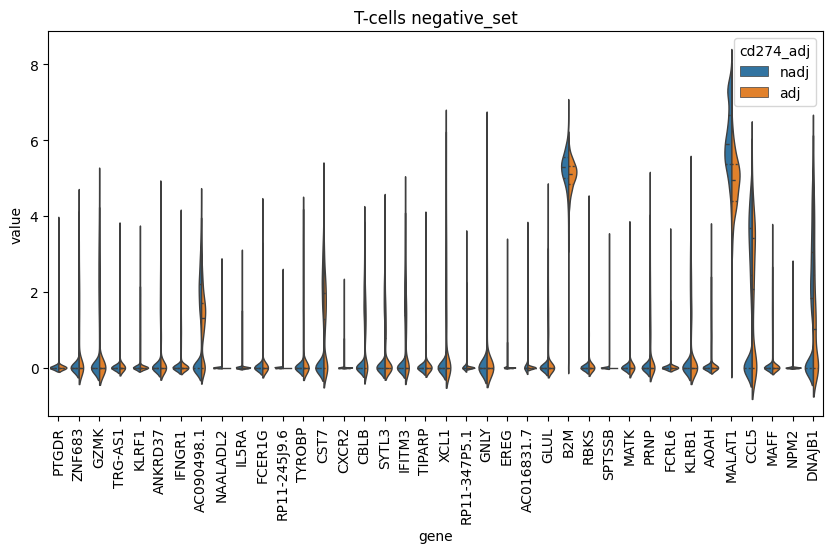

In [37]:
de_custom_plot(ad_ct[ad_ct.obs[gene + '_non_amb'].values],gene + '_adj', filtered_de_genes[gene]['neg'],title = ct_sel_label + ' negative_set')

Let's check how the different cells are distributed among the different T-cell subtypes

In [38]:
pd.crosstab(ad_ct.obs[gene + '_adj'],ad_ct.obs['celltype_minor'])

celltype_minor,Cycling T-cells,NK cells,NKT cells,T cells CD4+,T cells CD8+
cd274_adj,,,,,
adj,589,1,1,262,73
ambigious,521,49,37,2507,1060
nadj,230,1343,699,9852,7053
not_mapped,188,453,385,6610,3301


We see that there's a clear enrichment of Cycling T-cells in the 'adj' group.<br>
<br>
Next we'll check which cells that are more or less enriched for the pos/neg signatures we extracted

In [39]:
sc.tl.score_genes(ad_ct, filtered_de_genes[gene]['pos'], score_name= gene + '_pos_score')
sc.tl.score_genes(ad_ct, filtered_de_genes[gene]['neg'], score_name= gene + '_neg_score')

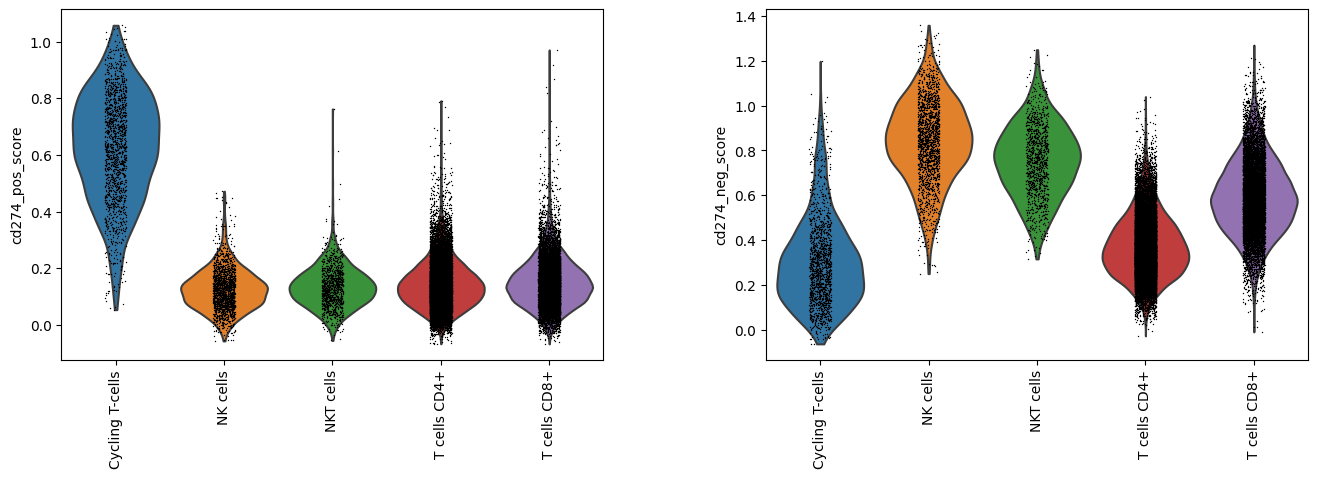

In [40]:
sc.pl.violin(ad_ct, keys=[gene + '_pos_score', gene + '_neg_score',], groupby='celltype_minor',rotation=90)

Again, clear separation of the cycling cells are more enriched for the signature. Let's see if this is true overall for any cycling cells

In [41]:
ad_sc.obs['cycling'] = pd.Categorical(['cycling' if 'Cycl' in x else 'non-cycling' for x in ad_sc.obs['celltype_minor'] ])

In [42]:
sc.tl.score_genes(ad_sc, filtered_de_genes[gene]['pos'], score_name= gene + '_pos_score')
sc.tl.score_genes(ad_sc, filtered_de_genes[gene]['neg'], score_name= gene + '_neg_score')

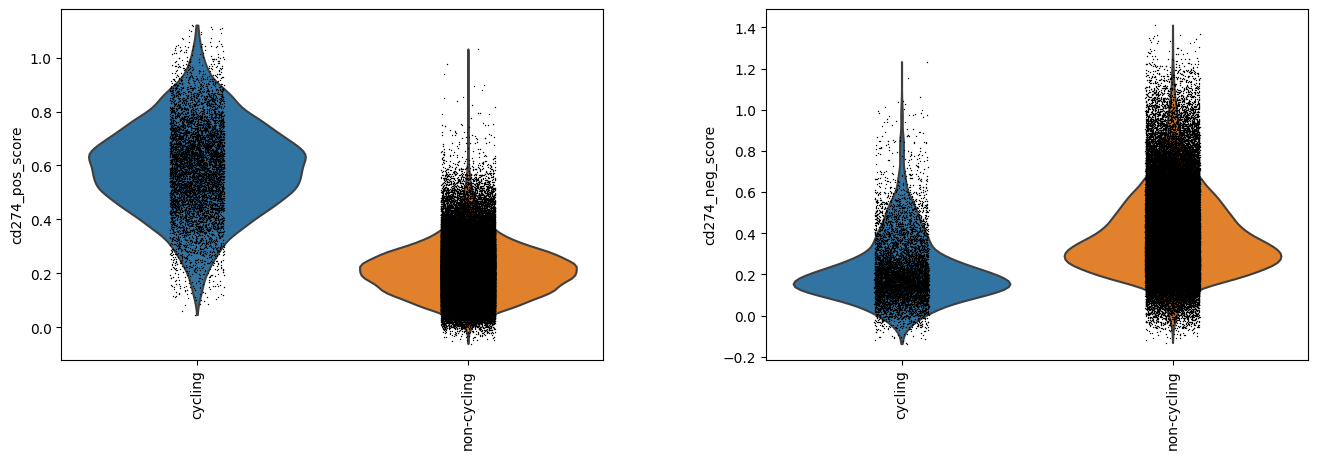

In [43]:
sc.pl.violin(ad_sc, keys=[gene + '_pos_score', gene + '_neg_score',], groupby='cycling',rotation=90)

In general, and not only for T-cells, Cycling cells seem to correlate with the signatures

To further assess this, we can use an _independent_ signature for proliferating/cycling cells downloaded from [here](). And see how this correlates with the positive T-cell signature (which seems to be related to cycling stuff).

In [44]:
# load gene list
with open(CYCLE_SIG_PTH,'r+') as f:
    cycling_sig = f.readlines()
    cycling_sig = [x.rstrip('\n') for x in cycling_sig]

In [45]:
sc.tl.score_genes(ad_sc,cycling_sig,score_name= 'cycling_score')

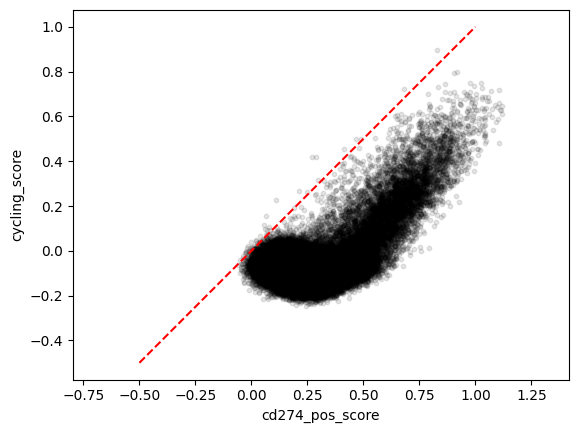

In [46]:
plt.scatter(ad_sc.obs['cd274_pos_score'],ad_sc.obs['cycling_score'],alpha = 0.1, s = 10,color = 'black')
plt.plot([-0.5,1],[-0.5,1],color = 'red', linestyle = 'dashed')
plt.axis('equal')
plt.xlabel('cd274_pos_score')
plt.ylabel('cycling_score')
plt.show()

Again, there seems to be a pretty strong correlation

If we look at how the receptor `PDCD1` is expressed in the different cells we have:

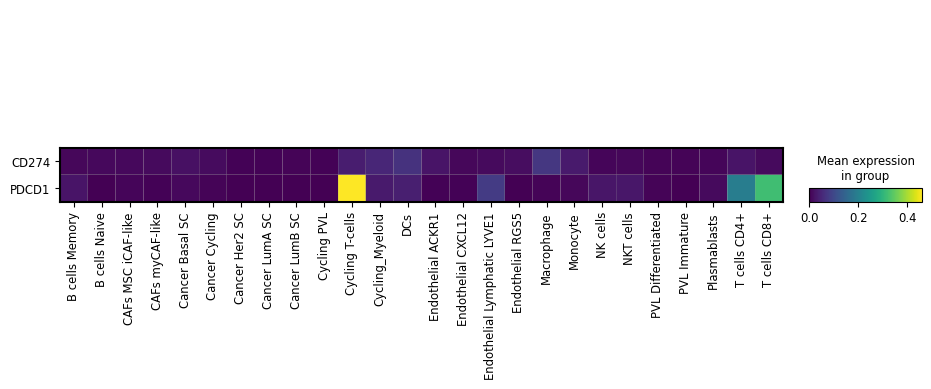

In [47]:
sc.pl.matrixplot(ad_sc, groupby='celltype_minor', var_names=['CD274','PDCD1'],swap_axes=True)

This is somewhat promising, saying that the Cycling T-cells actually seem to be expressing more of this receptor

We can also look at the difference in expression of this receptor among adjacent and non-adjacent T-cells (not only cycling)

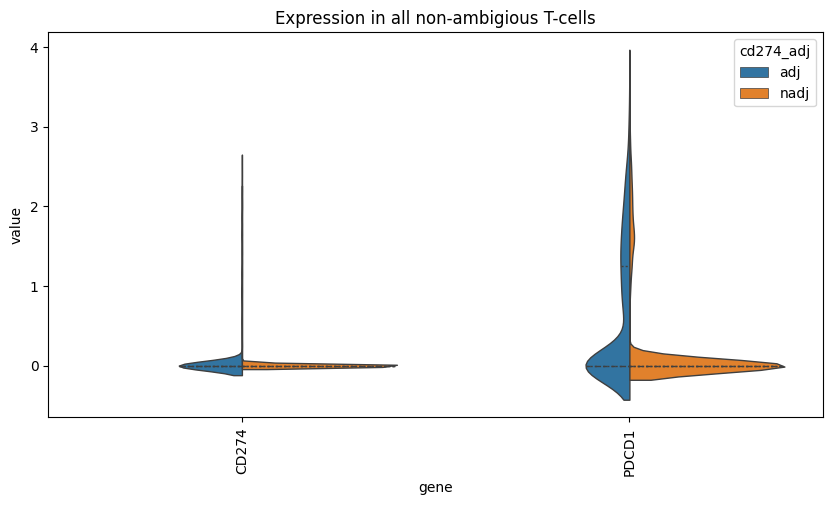

In [48]:
de_custom_plot(ad_ct[ad_ct.obs[gene + '_non_amb'].values], gene + '_adj', ['CD274','PDCD1'], title = 'Expression in all non-ambigious T-cells')

It seems like adjacent cells overall express more of the receptor, but also more of the ligand

---

# Alternative DE Approach

In the consensus approach, we do something very similar to Hejin's approach, but rather than iterating over samples we iterate over subtype and only compare cells that were consistently mapped (always same adj or nadj label). We do it on a per subtype basis to avoid major batch effects between TNBC and ER samples. This step can be removed tho.

In [49]:
ad_sc.obsm['adj_ind'] = gene_adj_indicator

subtype_list = list(ad_sp.obs['subtype'].unique())

num_de =1000
de_list = dict()


for gene in gene_list:
    de_list[gene] = dict()
    for subtype in subtype_list:
        de_list[gene][subtype] = dict(pos = set(), neg = set())

        group_name = gene + subtype + '_consensus_adj_ct'

        ad_sc.obs[group_name] =  ad_sc.obsm['adj_ind'][gene].astype(str) +\
        '_' + ad_sc.obs['subtype'].astype(str) + \
        '_' + ad_sc.obs[ct_label_col].astype(str)

        _g1_name = f'adj_{subtype}_{ct_label}'
        _g2_name = f'nadj_{subtype}_{ct_label}'

        n_g1 = sum(ad_sc.obs[group_name].values == _g1_name)
        n_g2 = sum(ad_sc.obs[group_name].values == _g2_name)

        # this step drops subtypes with fewer than two cells
        if (n_g1 < 2 )| (n_g2 < 2):
            print(f'subtype {subtype} has too few adj/nadj members. No DE test possible')
            del ad_sc.obs[group_name]
            continue
            
        sc.tl.rank_genes_groups(ad_sc, groupby =group_name, groups=[_g1_name], reference=_g2_name)
        de_df = sc.get.rank_genes_groups_df(ad_sc,group=_g1_name).sort_values('pvals_adj')

        de_df_pos = de_df.iloc[(de_df['pvals_adj'].values<0.05) & (de_df['scores'].values > 0)]
        #de_df_pos = de_df_pos.iloc[0:num_de,:]
        
        de_df_neg = de_df.iloc[(de_df['pvals_adj'].values<0.05) & (de_df['scores'].values < 0)]
        #de_df_neg = de_df_neg.iloc[0:num_de,:]
        

        de_list[gene][subtype]['pos'] = set(de_df_pos['names'].tolist())
        de_list[gene][subtype]['neg'] = set(de_df_neg['names'].tolist())

        del ad_sc.obs[group_name]

subtype ER has too few adj/nadj members. No DE test possible


In [50]:
filtered_de_genes = {gene : { sign : list(reduce(lambda a,b : a.intersection(b),[de_list[gene][subtype][sign] for subtype in subtype_list if len(de_list[gene][subtype][sign]) > 0])) for sign in ['pos','neg']} for gene in gene_list}

In [51]:
for gene in gene_list:
    for sign in ['pos','neg']:
        print(f'#genes in {gene} and set {sign} : {len(filtered_de_genes[gene][sign])}')

#genes in cd274 and set pos : 5710
#genes in cd274 and set neg : 983


### Redo some basic analys

In [52]:
sc.tl.score_genes(ad_ct, filtered_de_genes[gene]['pos'], score_name= gene + '_pos_score')
sc.tl.score_genes(ad_ct, filtered_de_genes[gene]['neg'], score_name= gene + '_neg_score')

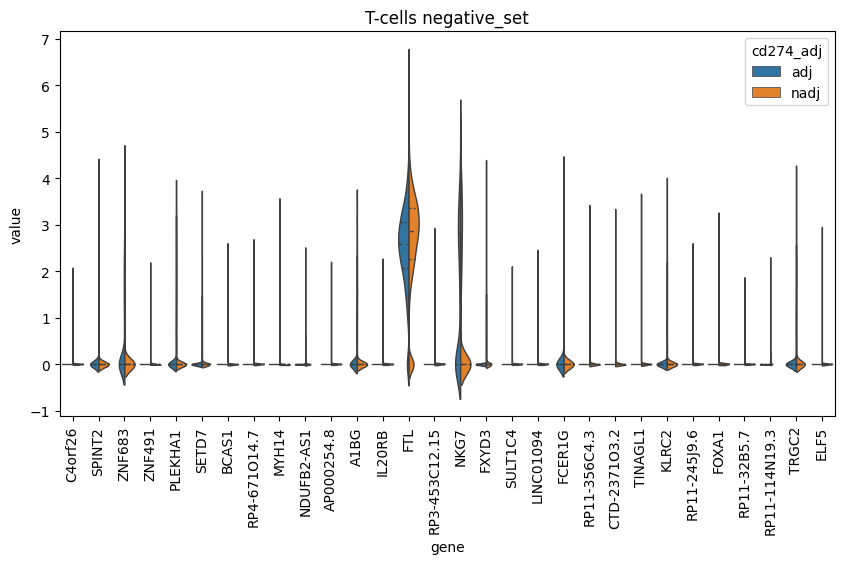

In [53]:
de_custom_plot(ad_ct[ad_ct.obs[gene + '_non_amb'].values],
               gene + '_adj',
               filtered_de_genes[gene]['neg'][0:30],
               title = ct_sel_label + ' negative_set')

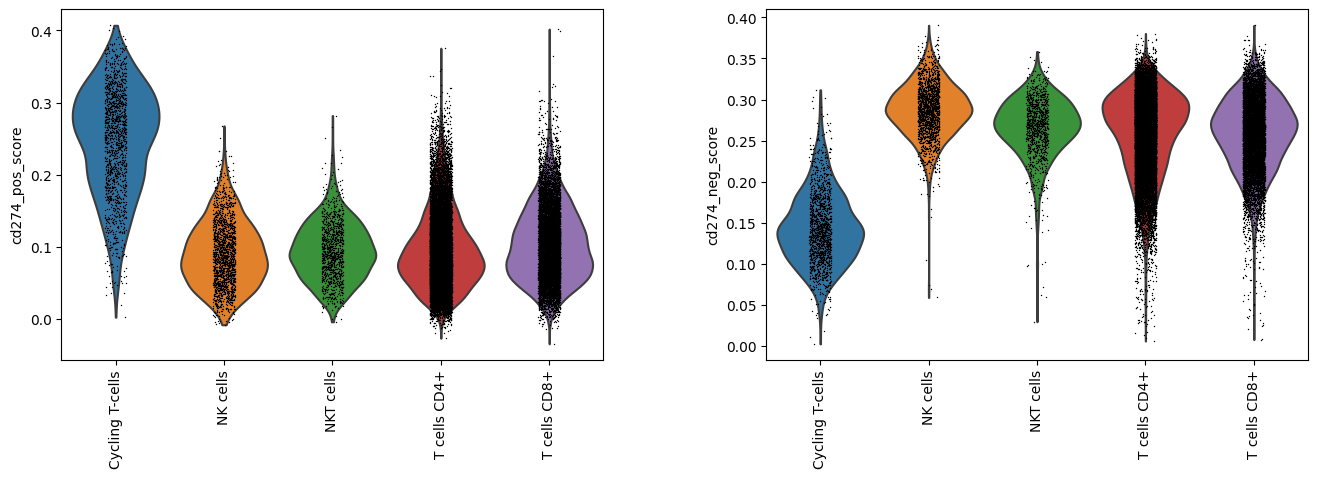

In [54]:
sc.pl.violin(ad_ct, keys=[gene + '_pos_score', gene + '_neg_score',], groupby='celltype_minor',rotation=90)